In [19]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from tqdm import tqdm

In [20]:
def util_map(is_malignant):
    if is_malignant:
        return 1
    else:
        return 0

total = pd.read_csv('data/ddi_metadata.csv')
total['aux'] = total['malignant'].map(util_map)
skin_tones = {}
skin_tones[12] = total.query('skin_tone == 12')
skin_tones[34] = total.query('skin_tone == 34')
skin_tones[56] = total.query('skin_tone == 56')

In [21]:
IMAGE_SIZE = (256, 256)
K = 150  # Number of visual words

def build_histogram(descriptors, kmeans_model, k):
    words = kmeans_model.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(k + 1))
    return hist

def extract_BVW_features(df):
    sift = cv2.SIFT_create()
    descriptors_list = []
    labels = [] 

    for row in df.to_dict(orient='records'):
        img = imread(f'data/{row['DDI_file']}')
        img = resize(img, (256, 256))
        descriptors = []

        for i in range(3):
            channel = img[:, :, i]
            channel_uint8 = (channel * 255).astype(np.uint8)
            kp, des = sift.detectAndCompute(channel_uint8, None)

            if des is not None and des.shape[1] == 128:
                descriptors.append(des)

        descriptors = np.vstack(descriptors)

        descriptors_list.append(descriptors)
        labels.append(row['aux'])
    

    all_descriptors = np.vstack(descriptors_list)
    print(f"Clustering {all_descriptors.shape[0]} descriptors into {K} visual words...")
    kmeans = MiniBatchKMeans(n_clusters=K, random_state=42)
    kmeans.fit(all_descriptors)

    X = np.array([build_histogram(des, kmeans, K) for des in descriptors_list])
    y = np.array(labels)

    return X, y

In [22]:
def predict_all(df, loops=100):
    X, y = extract_BVW_features(df)

    general_accuracy = 0
    general_precision = 0
    general_confusion_matrix = np.zeros((2, 2), dtype=float)

    for i in tqdm(range(loops)):

        sm = SMOTE()
        X_resampled, y_resampled = sm.fit_resample(X, y)

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        general_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1])

        general_accuracy += accuracy_score(y_test, y_pred)
        general_precision += precision_score(y_test, y_pred, average='macro')
    
    general_accuracy = general_accuracy/loops
    general_precision = general_precision/loops

    print('\n---------------------------------------------------')
    print(f'General Accuracy = {general_accuracy}')
    print(f'General Precision = {general_precision}')

    return general_confusion_matrix/loops

Clustering 321850 descriptors into 150 visual words...


/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████| 100/100 [00:21<00:00,  4.72it/s]



---------------------------------------------------
General Accuracy = 0.8446907216494839
General Precision = 0.845667295339497


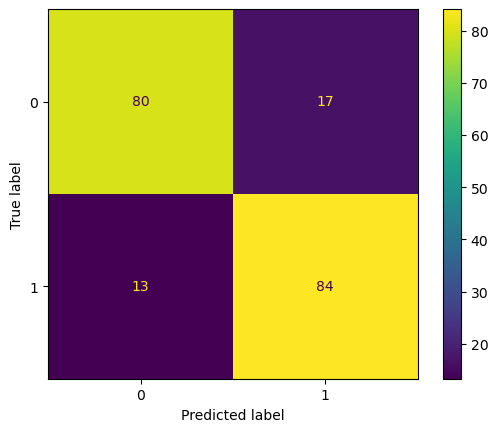

In [23]:
cm = predict_all(total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

Clustering 90064 descriptors into 150 visual words...


/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████| 100/100 [00:10<00:00, 10.00it/s]



---------------------------------------------------
General Accuracy = 0.8884375
General Precision = 0.8893371646763586


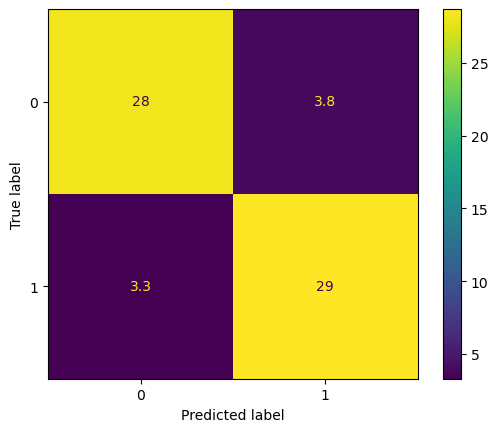

In [24]:
cm = predict_all(skin_tones[12])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

Clustering 117221 descriptors into 150 visual words...


/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


---------------------------------------------------
General Accuracy = 0.7980597014925372
General Precision = 0.8006378326369153


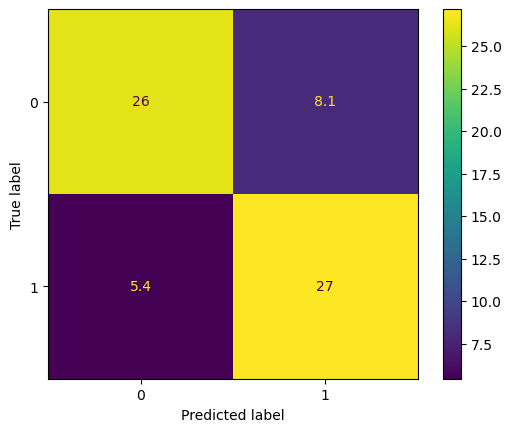

In [25]:
cm = predict_all(skin_tones[34])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

Clustering 114565 descriptors into 150 visual words...


/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████| 100/100 [00:09<00:00, 10.03it/s]



---------------------------------------------------
General Accuracy = 0.87390625
General Precision = 0.8766184524161926


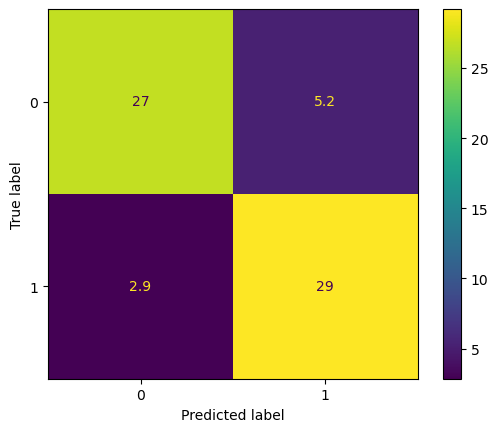

In [26]:
cm = predict_all(skin_tones[56])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()